# **Instructions**

This document is a template, and you are not required to follow it exactly. However, the kinds of questions we ask here are the kinds of questions we want you to focus on. While you might have answered similar questions to these in your project presentations, we want you to go into a lot more detail in this write-up; you can refer to the Lab homeworks for ideas on how to present your data or results. 

You don't have to answer every question in this template, but you should answer roughly this many questions. Your answers to such questions should be paragraph-length, not just a bullet point. You likely still have questions of your own -- that's okay! We want you to convey what you've learned, how you've learned it, and demonstrate that the content from the course has influenced how you've thought about this project.

# Frowning upon Bias: Exposing the Impact of Race on Emotion Classification
Project mentor: Mark Dredze

Kesavan Venkatesh, David Lu, Rishi Chandra, Liam Wang
kvenka10, dlu17, rchand18, wwang136

https://github.com/Lu-David/frowning-bias

# Outline and Deliverables

List the deliverables from your project proposal. For each uncompleted deliverable, please include a sentence or two on why you weren't able to complete it (e.g. "decided to use an existing implementation instead" or "ran out of time"). For each completed deliverable, indicate which section of this notebook covers what you did.

If you spent substantial time on any aspects that weren't deliverables in your proposal, please list those under "Additional Work" and indicate where in the notebook you discuss them.

### Uncompleted Deliverables
1. "Would like to accomplish #1" Compare the per-race accuracy results of our facial expression model with facial expression models of other popular facial expression models.
2. "Would like to accomplish #2" Explore other techniques to quantify and improve model fairness when training on skewed datasets.


### Completed Deliverables
1. "Must Accomplish #1": Determine the approximate race distribution of at least one popular facial expression dataset.
2. "Must Accomplish #2": Perform hyperparameter search to tune model with high overall accuracy.
3. "Must Accomplish #3": Train an effective model for facial expression classification using a popular facial expression dataset without stratification by race.
4. "Must Accomplish #4": Compare overall model accuracy on the dataset with the model accuracy on subsets of the dataset broken down by race.
5. "Expect to accomplish #1" Re-train our facial expression model using a stratified train/test split (same distribution in train vs test set) by race and compare overall and per-race model accuracy.
6. "Expect to accomplish #2" Re-train our facial expression model using a stratified train/test split and stratified sampling within groups (same number of each category in each set) by race and compare overall and per-race model accuracy.
7. "Expect to accomplish #3" Perform analysis on model accuracy on the train/test set when broken down by race and facial expression to identify which facial expressions are most likely to be misclassified when considering the distribution of race.
8. "Would like to accomplish #3" Introduce additional dependent variables to compare accuracy across, such as gender or age.

9. "Must complete #1": We discuss our dataset pre-processing [in "Dataset" below](#scrollTo=zFq-_D0khnhh&line=10&uniqifier=1).
10. "Must complete #2": We discuss training our logistic regression baseline [in "Baselines" below](#scrollTo=oMyqHUa0jUw7&line=5&uniqifier=1).
11. ...


### Additional Deliverables
1. We introduced data augmentation to see if varying lighting conditions would make the model more agnostic to demographic characteristics. We discuss this in "Data Augmentation" section below.
2. We trained an "Attribute Aware" model that takes demographic information as an input to see if this would make the model more fair. We discuss this in "Attribute Aware Model" section below.

# Preliminaries

## What problem were you trying to solve or understand?

What are the real-world implications of this data and task?

How is this problem similar to others we’ve seen in lectures, breakouts, and homeworks?

What makes this problem unique?

What ethical implications does this problem have?

## Dataset(s)

Describe the dataset(s) you used.

How were they collected?

Why did you choose them?

How many examples in each?


In [1]:
# Run this cell if using google colab
from google.colab import drive

%cd /content
! rm -rf frowning-bias
! git clone https://github.com/Lu-David/frowning-bias -b main
%cd  frowning-bias

ModuleNotFoundError: No module named 'google'

In [2]:
from download_data import download_raf

download_raf()

Unzipping data/RAF/aligned_test.zip
Unzipping data/RAF/aligned_train.zip
Unzipping data/RAF/manual.zip


In [3]:
import os
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# 	Gender
# 	0: male		1: female	2: unsure
#    ----------------------------------------------------------------------
# 	Race
# 0: Caucasian		1: African-American		2: Asian
# ----------------------------------------------------------------------
# 	Age (5 ranges)
# 0: 0-3	 1: 4-19		2: 20-39		3: 40-69		4: 70+
# NOTE: raw txt file has emotion labels 1-indexed, I am shifting to zero-indexing
emotion_lookup = {
    0: "Surprise",
    1: "Fear",
    2: "Disgust",
    3: "Happiness",
    4: "Sadness",
    5: "Anger",
    6: "Neutral"
}

race_lookup = {
    0: "Caucasian",
    1: "African-American",
    2: "Asian"
}

gender_lookup = {
    0: "Male",
    1: "Female",
    2: "Unsure"
}

age_lookup = {
    0: "0-3",
    1: "4-19",
    2: "20-39",
    3: "40-69",
    4: "70+"
}

# Construct dataframe for train/test data attributes
data_dir = Path("./data")
raf_dir = data_dir / "RAF"
train_dir = raf_dir / "aligned_train"
test_dir = raf_dir / "aligned_test"
annot_dir = raf_dir / "manual"
labels_file = raf_dir / "list_partition_label.txt"
df = pd.read_csv(labels_file, sep=" ", header=None)
df.columns = ["Name", "Emotion"]
df["Path"] = df["Name"].apply(lambda x: os.path.join(str(train_dir), x.replace(".jpg","_aligned.jpg")) if ("train" in x) else os.path.join(str(test_dir), x.replace(".jpg","_aligned.jpg")))
df["Split"] = df["Name"].apply(lambda x: "Train" if ("train" in x) else "Test")
gender = []
race = []
age = []
for i,r in df.iterrows():
    annot_file = os.path.join(str(annot_dir), "{}_manu_attri.txt".format(r["Name"].replace(".jpg","")))
    with open(annot_file, "r") as f:
        lines = f.readlines()
        gender.append(int(lines[5]))
        race.append(int(lines[6]))
        age.append(int(lines[7]))
df["Gender"] = gender
df["Race"] = race
df["Age"] = age
# NOTE: raw txt file has emotion labels 1-indexed, I am shifting to zero-indexing
df["Emotion"] = df["Emotion"] - 1
df["EmotionLabel"] = df["Emotion"].apply(lambda x: emotion_lookup[x])
df["RaceLabel"] = df["Race"].apply(lambda x: race_lookup[x])
df["GenderLabel"] = df["Gender"].apply(lambda x: gender_lookup[x])
df["AgeLabel"] = df["Age"].apply(lambda x: age_lookup[x])
df_train = df[df["Split"]=="Train"]
df_test = df[df["Split"]=="Test"]
assert len(df) == len(df_train) + len(df_test)

/var/folders/_c/4nyz6w6s1cq61c91lh5vxq5m0000gn/T/ipykernel_87648/4268783481.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  img_path = df[df["Age"]==i][df["Gender"]==(j < num_show)].sample(1, random_state=random_state)["Path"].values[0]


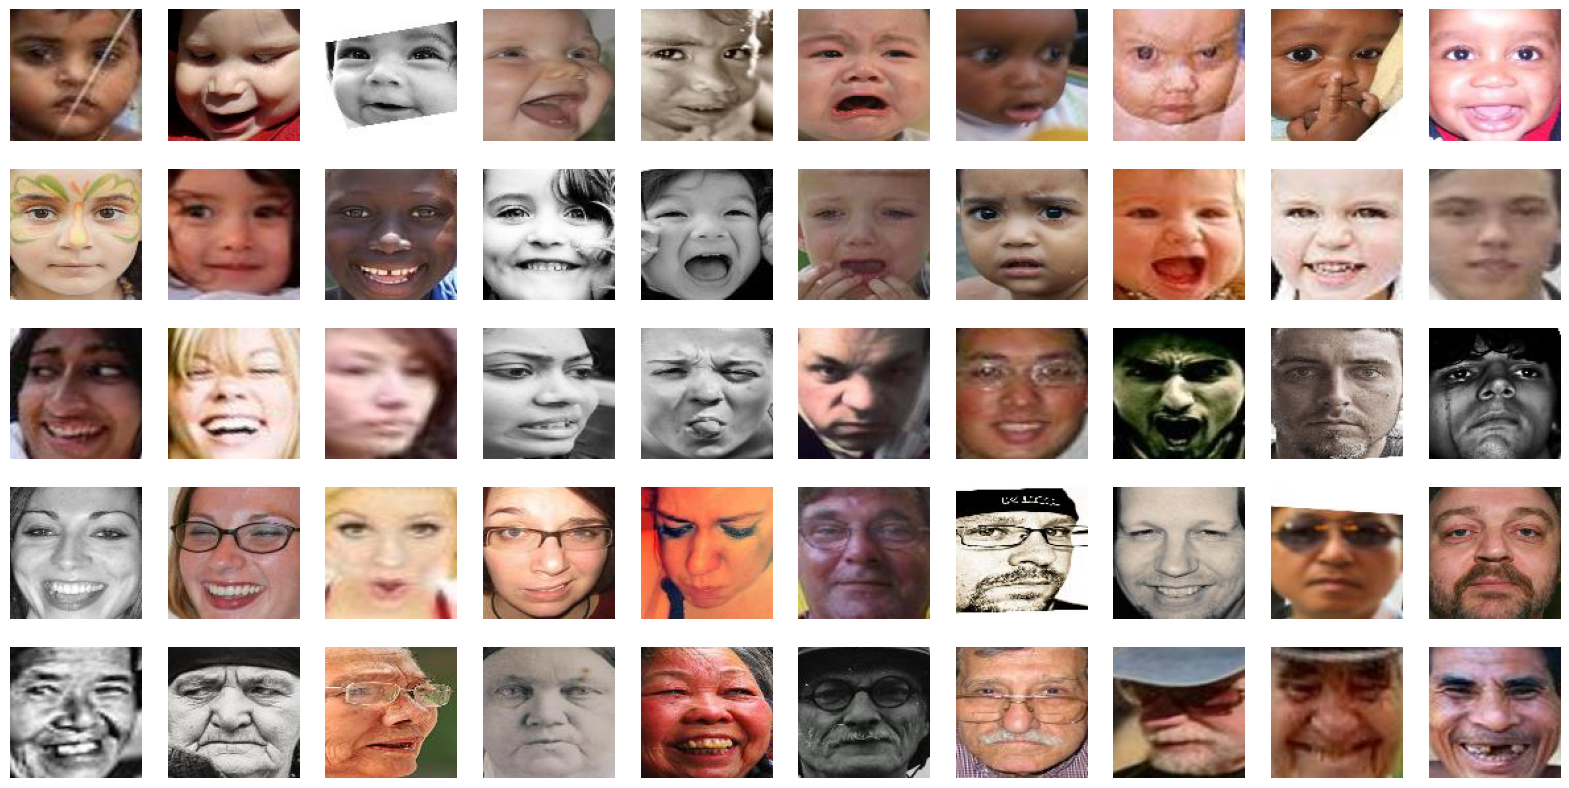

In [6]:
from PIL import Image
from numpy.random import RandomState

# plot a few examples for every age group
random_state = RandomState(0)
num_show = 5
fig, ax = plt.subplots(nrows=5, ncols=num_show*2, figsize=(num_show*2*2,5*2))
for i in range(5):
    for j in range(num_show*2):
        img_path = df[df["Age"]==i][df["Gender"]==(j < num_show)].sample(1, random_state=random_state)["Path"].values[0]
        img = Image.open(img_path)
        ax[i,j].imshow(img)
        # ax[i,j].set_title(img_path.split("/")[-1])
        ax[i,j].axis("off")
plt.show()

## Pre-processing

What features did you use or choose not to use? Why?

If you have categorical labels, were your datasets class-balanced?

How did you deal with missing data? What about outliers?

What approach(es) did you use to pre-process your data? Why?

Are your features continuous or categorical? How do you treat these features differently?

In [ ]:
# For those same examples above, what do they look like after being pre-processed?

In [ ]:
# Visualize the distribution of your data before and after pre-processing.
#   You may borrow from how we visualized data in the Lab homeworks.

# Models and Evaluation

## Experimental Setup

How did you evaluate your methods? Why is that a reasonable evaluation metric for the task?

What did you use for your loss function to train your models? Did you try multiple loss functions? Why or why not?

How did you split your data into train and test sets? Why?


In [ ]:
# Code for loss functions, evaluation metrics or link to Git repo

## Baselines 

What baselines did you compare against? Why are these reasonable?

Did you look at related work to contextualize how others methods or baselines have performed on this dataset/task? If so, how did those methods do?

## Methods

What methods did you choose? Why did you choose them?

How did you train these methods, and how did you evaluate them? Why?

Which methods were easy/difficult to implement and train? Why?

For each method, what hyperparameters did you evaluate? How sensitive was your model's performance to different hyperparameter settings?

In [ ]:
# Code for training models, or link to your Git repository

In [ ]:
# Show plots of how these models performed during training.
#  For example, plot train loss and train accuracy (or other evaluation metric) on the y-axis,
#  with number of iterations or number of examples on the x-axis.

## Results

Show tables comparing your methods to the baselines.

What about these results surprised you? Why?

Did your models over- or under-fit? How can you tell? What did you do to address these issues?

What does the evaluation of your trained models tell you about your data? How do you expect these models might behave differently on different data?  

In [ ]:
# Show plots or visualizations of your evaluation metric(s) on the train and test sets.
#   What do these plots show about over- or under-fitting?
#   You may borrow from how we visualized results in the Lab homeworks.
#   Are there aspects of your results that are difficult to visualize? Why?

# Discussion

## What you've learned

*Note: you don't have to answer all of these, and you can answer other questions if you'd like. We just want you to demonstrate what you've learned from the project.*

What concepts from lecture/breakout were most relevant to your project? How so?

What aspects of your project did you find most surprising?

What lessons did you take from this project that you want to remember for the next ML project you work on? Do you think those lessons would transfer to other datasets and/or models? Why or why not?

What was the most helpful feedback you received during your presentation? Why?

If you had two more weeks to work on this project, what would you do next? Why?